In [1]:
import datamol as dm 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from umap import UMAP
from scipy.cluster import hierarchy
import random 
import torch
from random import shuffle
import pytorch_lightning as pl 
pl.seed_everything(0)
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
g = torch.Generator()
g.manual_seed(0)

%load_ext autoreload
%autoreload 2


/opt/homebrew/Caskroom/miniconda/base/envs/clustermargin/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/envs/clustermargin/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/min

In [2]:

def get_dummy_data():
    # set seed
    #np.random.seed(42)
    data = dm.data.chembl_drugs()
    data["mol"] = data["smiles"].apply(dm.to_mol)
    data["fp"] = data["mol"].apply(dm.to_fp)
    umap = UMAP(n_components=2)
    emb_2d = umap.fit_transform(np.vstack(data["fp"].values))
    data["x"] = emb_2d[:,0]
    data["y"] = emb_2d[:,1]
    a = torch.rand((len(data),5))
    a = a / a.sum(dim=1, keepdim=True)
    data["prob0"] = a[:,0]
    data["prob1"] = a[:,1]
    data["prob2"] = a[:,2]
    data["prob3"] = a[:,3]
    data["prob4"] = a[:,4]
    return data
data=get_dummy_data()

In [3]:
data.head()

,smiles,mol,fp,x,y,prob0,prob1,prob2,prob3,prob4
0,Br.CC(N)Cc1ccc(O)cc1,<rdkit.Chem.rdchem.Mol object at 0x284459f50>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.400651,1.071365,0.276866,0.428597,0.049362,0.073661,0.171514
1,Br.CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x28445a0a0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.968798,1.828140,0.203979,0.157660,0.288380,0.146572,0.203409
2,Br.CC1C2Cc3ccc(O)cc3C1(C)CCN2CCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x28445a110>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.802108,1.041664,0.282348,0.325097,0.018068,0.136652,0.237835
3,Br.CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c...,<rdkit.Chem.rdchem.Mol object at 0x28445a180>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.409545,2.562161,0.210824,0.283662,0.325274,0.065472,0.114767
4,Br.CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21,<rdkit.Chem.rdchem.Mol object at 0x28445a1f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",9.054525,0.844971,0.207336,0.278389,0.120792,0.265906,0.127578


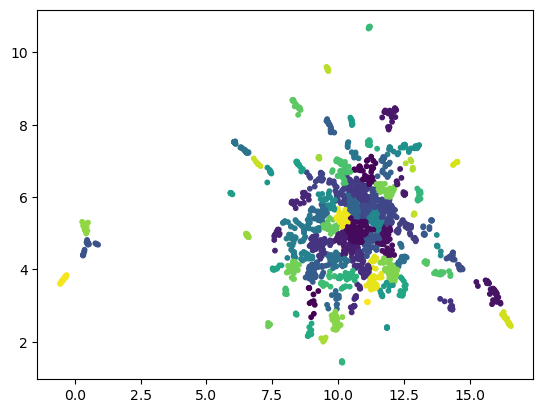

In [4]:
# plot umap 
umap = UMAP(n_components=2)
emb_2d = umap.fit_transform(np.vstack(data["fp"].values))
#plt.plot(emb_2d[:, 0], emb_2d[:, 1], "o", alpha=0.5)
# cluster with AgglomerativeClustering
clust = AgglomerativeClustering(n_clusters=None, linkage="average", distance_threshold=0.5).fit(emb_2d)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=clust.labels_, s=10)

In [79]:
def random_sample(data, n):
    idxs = np.random.choice(np.arange(len(data)), n, replace=False)
    return data[idxs], idxs

def initialization_step(pool, n=30):
    labeled_examples, idxs = random_sample(pool.to_numpy(), n)
    x = pool["x"].to_numpy()
    y = pool["y"].to_numpy()
    clust = AgglomerativeClustering(n_clusters=None, linkage="average", distance_threshold=0.5).fit(np.vstack((x, y)).T)
    return {"label_examples": labeled_examples,
            "label_idxs": idxs,
             "clustering": clust}

def get_unlabelled(pool, idxs):
    all_idxs = np.arange(len(pool))
    mask = np.ones(len(all_idxs), dtype=bool)
    mask[idxs]=False
    unlabelled_idxs = all_idxs[mask]
    return pool[unlabelled_idxs], unlabelled_idxs


def calculate_margin_score(self, probs , n:int):
    idxs_unlabeled = np.arange(self.n_pool)[~self.idxs_labeled]
    if isinstance(probs, torch.Tensor):
        probs_sorted, idxs = probs.sort(descending=True)
        U = probs_sorted[:, 0] - probs_sorted[:,1]
        return idxs_unlabeled[U.sort()[1].numpy()[:n]]
    probs_sorted, idxs = np.sort(probs, axis=1)[:,::-1] # invert columns
    U = probs_sorted[:, 0] - probs_sorted[:,1]
    return idxs_unlabeled[np.argsort(U)[:n]]

def get_probabilities(data):
    probs = data[["prob0", "prob1", "prob2", "prob3", "prob4"]].to_numpy()
    return probs

def get_mask(pool, idxs):
    # crearte a mask
    all_idxs = np.arange(len(pool))
    mask = np.zeros(len(all_idxs), dtype=bool)
    mask[idxs]=True
    return mask

def get_M(pool, idxs, km=5):
    # get the mask of the selected examples from the margin score criteria
    mask = get_mask(pool, idxs)
    all_probs = get_probabilities(pool)
    probs = all_probs[mask]
    probs_sorted= np.sort(probs, axis=1)[:,::-1] # invert columns
    U = probs_sorted[:, 0] - probs_sorted[:,1] # margin score
    return np.argsort(U)[:km]#, idxs[np.argsort(U)[:km]]

def completeiteration(pool, n=30, km=30 , kt = 10):
    assert kt < km , "kt must be smaller than km"
    examples = np.vstack((pool["x"].to_numpy(), pool["y"].to_numpy())).T
    init=initialization_step(pool, n)
    unlabelled_examples, unlabelled_idxs = get_unlabelled(pool.to_numpy(), init["label_idxs"])
    #return examples[get_M(pool, unlabelled_idxs)]
    M_idxs =get_M(pool, unlabelled_idxs, km)
    cluster_list = get_sorted_cluster_list(init["clustering"], M_idxs)
    idxs = round_robin_sampling(cluster_list, kt)
    return init, unlabelled_examples, unlabelled_idxs, examples[M_idxs], examples[idxs]


def round_robin_sampling(cluster_list,k):
    index_select = []
    cluster_index = 0
    # on each cluster select one element, then go to the next cluster by size
    # if the cluster is empty, go to the next one
    # if it is the last cluster, go to the first one
    while k > 0:
        if len(cluster_list[cluster_index]) > 0:
            # pop a random element from the selected cluster
            shuffle(cluster_list[cluster_index])
            index_select.append(cluster_list[cluster_index].pop(0))

            #index_select.append(cluster_list[cluster_index].pop(0)) 
            k -= 1
        if cluster_index < len(cluster_list) - 1:
            cluster_index += 1
        else:
            if len(cluster_list[cluster_index]) == 0: # escape condition if k > number of clusters
                break
            cluster_index = 0
    return index_select

def get_sorted_cluster_list(clust, set_unlabelled_idxs):
    # create a list for each cluster
    # for every unlabelled idx, append it to the corresponding cluster
    # by finding the cluster index in the clust.labels_ array
    clust_list = [[] for _ in range(clust.n_clusters_)] 
    for idx in set_unlabelled_idxs:
        cluster_idx=clust.labels_[idx]
        clust_list[cluster_idx].append(idx)
    clust_list.sort(key=lambda x:len(x))
    # remove empty clusters
    clust_list = [x for x in clust_list if x != []]
    return clust_list

def iteration(pool, init, labelled_idxs, n=30, km=30 , kt = 10):
    unlabelled_examples, unlabelled_idxs = get_unlabelled(pool.to_numpy(), labelled_idxs)
    #return examples[get_M(pool, unlabelled_idxs)]
    M_idxs=get_M(pool, unlabelled_idxs, km)
    cluster_list = get_sorted_cluster_list(init["clustering"], M_idxs)
    idxs = round_robin_sampling(cluster_list, kt)
    return idxs


def cluster_margin(pool, n=30, km=30 , kt = 10, it =1):
    assert kt < km , "kt must be smaller than km"
    examples = np.vstack((pool["x"].to_numpy(), pool["y"].to_numpy())).T
    init=initialization_step(pool, n)
    tmp=[]
    for i in range(it):
        #print(len(init["label_idxs"]))
        new_idxs = iteration(pool, init, init["label_idxs"], n, km , kt)
        init["label_idxs"] = np.concatenate((init["label_idxs"], new_idxs))
        tmp.append(examples[new_idxs])
    return tmp



plt.figure(figsize=(10,10))
test = completeiteration(data, 20, km = 60, kt=10)
#test2 = cluster_margin(data, 20, km = 60, kt=10, it=1)
plt.scatter(data["x"].to_numpy(), data["y"].to_numpy(), c=test[0]["clustering"].labels_, s=10,
             cmap='twilight', label="clusters", marker="x")
plt.scatter(data["x"].to_numpy()[test[0]["label_idxs"]], data["y"].to_numpy()[test[0]["label_idxs"]], c="red",
             label="train pts", marker="o")
for n,i in enumerate(cluster_margin(data, 20, km = 60, kt=10, it=3)):
    plt.scatter(i[:,0], i[:,1], marker="x", label=f"iter_{n+1}")
plt.legend()



[3.74803543e-02 2.63834387e-01 1.24642968e-01 3.13556790e-02
 2.49899626e-02 8.77066851e-02 5.19996136e-02 3.93711030e-02
 1.46776557e-01 1.74597383e-01 2.84262449e-02 8.57678354e-02
 1.17664397e-01 3.94681096e-03 2.39044428e-04 6.99465871e-02
 4.95981276e-02 1.13599896e-02 1.85133815e-02 3.05672944e-01
 1.09220624e-01 2.07636058e-02 8.78315568e-02 4.16362435e-02
 1.00811422e-02 1.69434905e-01 1.43829197e-01 5.01500815e-02
 3.98448706e-02 1.06751144e-01 4.80587631e-02 6.38477206e-02
 2.82550156e-02 7.19587505e-03 2.86245286e-01 2.80025750e-02
 1.62205398e-02 1.01061314e-01 1.67591274e-01 1.08824462e-01
 4.85205650e-02 1.12974942e-02 1.78968012e-02 3.91549766e-02
 1.01137906e-01 1.24138296e-02 4.81553674e-02 1.40220970e-01
 6.88552856e-02 2.56197274e-01 6.22344315e-02 1.44849122e-02
 1.16625264e-01 4.70011532e-02 4.64021266e-02 3.79700065e-02
 7.60027170e-02 1.38900429e-01 6.76038861e-02 1.54402286e-01]
[9.53376293e-05 1.02579594e-04 1.73240900e-04 1.90332532e-04
 1.90347433e-04 2.04175

NameError: name 'ex' is not defined

<Figure size 1000x1000 with 0 Axes>

In [76]:
cluster_margin(data, 20, km = 60, kt=10, it=1)

[ 799 1186  258  358 1320  603   76  579 1446   28 1538  602  155 1789
   75  967  812 1031  621  412 1067  172 1032  607  387  282 1161  921
  928  718  306 1711 1561 1150 1611  661  761  288  447 1760 1328  430
 1550 1269 1114  296  642  773 1229 1528   30 1030 1260 1281 1296 1673
  297 1272  867  578]
[ 790 1173  254  354 1306  595   75  571 1430   28 1522  594  151 1770
   74  958  803 1020  613  408 1055  168 1021  599  383  278 1148  912
  919  709  302 1693 1545 1137 1594  653  752  284  443 1741 1314  426
 1534 1256 1102  292  634  764 1216 1512   30 1019 1247 1267 1282 1655
  293 1259  858  570]


[array([[ 7.7567396 , -0.3248663 ],
        [ 7.436887  ,  0.6463163 ],
        [ 7.2101836 ,  2.7517238 ],
        [ 7.1032476 ,  1.3697138 ],
        [ 8.113965  ,  1.0273055 ],
        [ 7.7926393 ,  2.8436935 ],
        [ 5.768154  ,  5.814193  ],
        [ 6.0196877 ,  2.2613585 ],
        [ 9.404284  ,  2.134542  ],
        [11.982034  ,  0.46908227]], dtype=float32)]

[[0.2768657  0.42859733 0.04936229 0.07366091 0.17151375]
 [0.20397885 0.15765975 0.28838027 0.14657246 0.20340869]
 [0.28234848 0.32509714 0.01806753 0.13665222 0.23783465]
 ...
 [0.27408767 0.3109613  0.01878815 0.22488311 0.17127974]
 [0.25960195 0.20768382 0.16649084 0.2697574  0.09646596]
 [0.069072   0.08217077 0.49828023 0.29620048 0.05427653]]
[ 791 1174  254  354 1308  595   75  571 1433   27 1525  594  151 1771
   74  958  804 1020  613  406 1056  168 1021  599  382  278 1149  912
  919  710  302 1694 1548 1138 1597  653  753  284  441 1742 1316  424
 1537 1257 1103  292  634  765 1217 1515   29 1019 1248 1269 1284 1659
  293 1260  859  570]


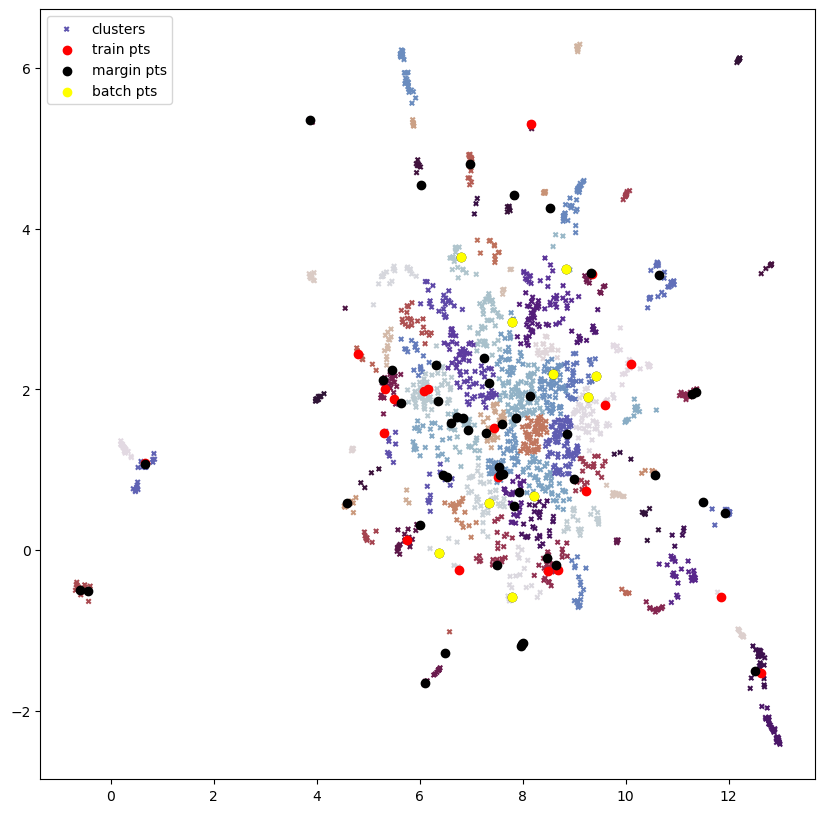

In [21]:
plt.figure(figsize=(10,10))
test = iteration(data, 20, km = 60, kt=10)
plt.scatter(data["x"].to_numpy(), data["y"].to_numpy(), c=test[0]["clustering"].labels_, s=10,
             cmap='twilight', label="clusters", marker="x")
plt.scatter(data["x"].to_numpy()[test[0]["label_idxs"]], data["y"].to_numpy()[test[0]["label_idxs"]], c="red",
             label="train pts", marker="o")
plt.scatter(*test[3].T, color="black", marker="o", label="margin pts")
plt.scatter(*test[4].T, color="yellow", marker="o", label="batch pts")
plt.legend()
